<a href="https://colab.research.google.com/github/KelllyChen/Machine-Learning-Court/blob/Colab/Machine_Learning_Court_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ⚖️ Case 1: Loan Denial Dispute – UCI Adult Income Dataset
### 🔍 Scenario
Jane Dow, a 37-year-old professional woman with a Bachelor's degree and full-time executive role, applied for a premium credit product. The bank’s model—trained to predict income level as a proxy for eligibility—classified her as earning ≤$50K, resulting in denial. She disputes the fairness of the decision.

### 🟥 Prosecution
Evaluate whether the model’s decision may have been influenced by inappropriate or unfair reasoning. Explore whether the explanation aligns with what should be expected in a fair credit decision.

### 🟦 Defense
Justify the decision based on the model’s learned patterns. Consider how well the explanation supports the classification and whether similar profiles are treated consistently.

In [30]:
!pip install lime==0.2.0.1

`y = df["class"].apply(lambda x: 1 if x == '>50K' else 0)`

Above line was wrongly put after encoders lead to all target variables be labeled as 0, so I adjusted the code to keep the accurate values.

In [31]:
# 📦 Case 1: Loan Approval Prediction (Adult Income Dataset)

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Load Data
from sklearn.datasets import fetch_openml
adult = fetch_openml(name='adult', version=2, as_frame=True)
df = adult.frame

# Clean and preprocess
df = df.dropna()
df = df.copy()

y = df["class"].apply(lambda x: 1 if x == '>50K' else 0)

encoders = {}
label_cols = df.select_dtypes(include='category').columns.tolist()

for col in label_cols:
    le = LabelEncoder()
    df[col] = df[col].astype(str)
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

X = df.drop(["class", "fnlwgt"], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train simple RF model
model_adult = RandomForestClassifier(random_state=42)
model_adult.fit(X_train, y_train)
print(classification_report(y_test, model_adult.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      6842
           1       0.72      0.61      0.66      2203

    accuracy                           0.85      9045
   macro avg       0.80      0.77      0.78      9045
weighted avg       0.84      0.85      0.84      9045



In [32]:
# 🎯 Focus Instance: Loan Rejection Case (Jane Dow)

jane_encoded = {
    'age': 37,
    'workclass': encoders['workclass'].transform(['Private'])[0],
    'education': encoders['education'].transform(['Bachelors'])[0],
    'marital-status': encoders['marital-status'].transform(['Never-married'])[0],
    'occupation': encoders['occupation'].transform(['Exec-managerial'])[0],
    'relationship': encoders['relationship'].transform(['Not-in-family'])[0],
    'race': encoders['race'].transform(['White'])[0],
    'sex': encoders['sex'].transform(['Female'])[0],
    'hours-per-week': 50,
    'native-country': encoders['native-country'].transform(['United-States'])[0],
    'capital-gain': 0,
    'capital-loss': 0,
    'education-num': 13,
}

jane_df = pd.DataFrame([jane_encoded])
jane_df = jane_df[X_train.columns]
pred = model_adult.predict(jane_df)
print("Prediction for Jane Dow (Loan Eligibility):", "Approved" if pred[0] == 1 else "Denied")

Prediction for Jane Dow (Loan Eligibility): Denied


In [33]:
print("Classes:", model_adult.classes_)
print("Proba shape:", model_adult.predict_proba(jane_df).shape)

Classes: [0 1]
Proba shape: (1, 2)


In [34]:
print(y.value_counts())
print(y_train.value_counts())
print(y_test.value_counts())

class
0    34014
1    11208
Name: count, dtype: int64
class
0    27172
1     9005
Name: count, dtype: int64
class
0    6842
1    2203
Name: count, dtype: int64


# SHAP

In [35]:
import shap
explainer = shap.Explainer(model_adult, X_train)
shap_values = explainer(X_test)

100%|===================| 18088/18090 [33:07<00:00]       

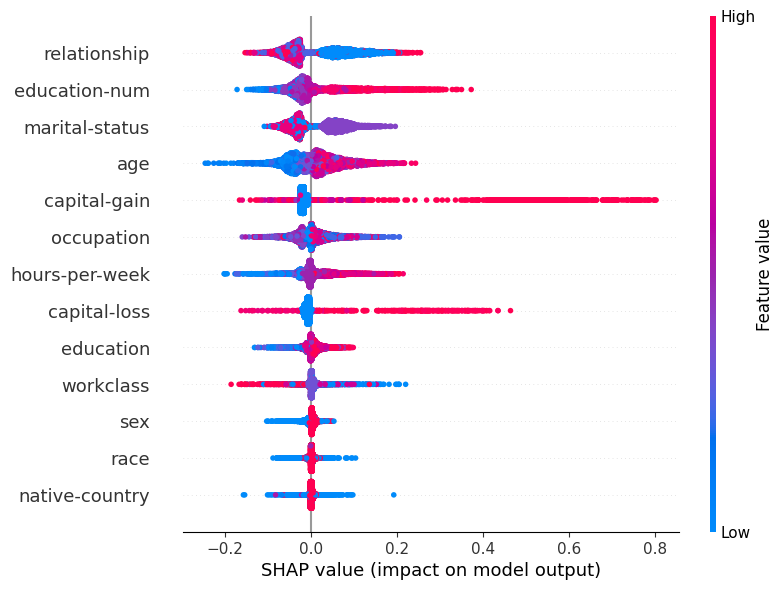

In [36]:
# Select class-1 SHAP values only
class1_shap_values = shap_values[:, :, 1]


shap.plots.beeswarm(class1_shap_values, max_display=len(X_train.columns))



# Intepretation: Summary Plot – global explanation across all samples
**This is the distribution of SHAP values across the dataset.**
- Top global drivers:
  - **Relationship, education-num and marital-status** are dominant factors based on the plot.
  - **Education-num, age, capital-gain, hours-per-week, capital-loss, education** all show positive effects at higher values (red → higher feature value → more likely higher prediction).
  - Compared to other features, **capital-gain** has extreme positive pushes for certain individuals.
- Less influential globally:
  - **Sex, race, and native-country** have low SHAP vlaues means that the model does not rely heavily on these features directly.

**Critical issue:**
The model places substantial weight on relationship and marital-status. These are not fair or business-justified predictors for loan approval. Even if statistically correlated with outcomes, their inclusion raises serious fairness concerns and may reflect intrinsic systemic biases.




In [37]:
import matplotlib.pyplot as plt

def print_mapping(feature, encoder):
    """Prints label encoder mapping for a given feature."""
    print(f"\n{feature} MAPPING:")
    for i, category in enumerate(encoder.classes_):
        print(f"  {i}: {category}")
    print("="*50)

def shap_dependence_plot(feature, shap_values, X_sample, encoder=None):
    """Creates a SHAP dependence plot."""
    X_plot = X_sample.copy()
    if encoder is not None:
        mapping = dict(enumerate(encoder.classes_))
        X_plot[feature] = X_plot[feature].map(mapping)
        print_mapping(feature, encoder)

    shap.dependence_plot(
        feature,
        shap_values.values,
        X_sample,
        feature_names=X_sample.columns
    )



marital-status MAPPING:
  0: Divorced
  1: Married-AF-spouse
  2: Married-civ-spouse
  3: Married-spouse-absent
  4: Never-married
  5: Separated
  6: Widowed


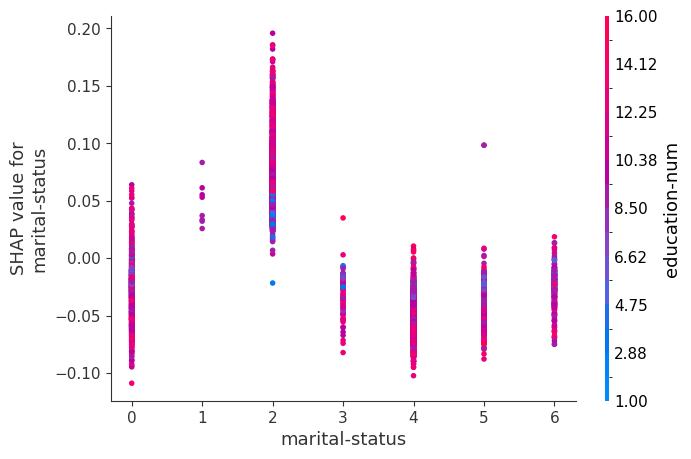

In [38]:
shap_dependence_plot("marital-status", class1_shap_values, X_test, encoders['marital-status'])


relationship MAPPING:
  0: Husband
  1: Not-in-family
  2: Other-relative
  3: Own-child
  4: Unmarried
  5: Wife


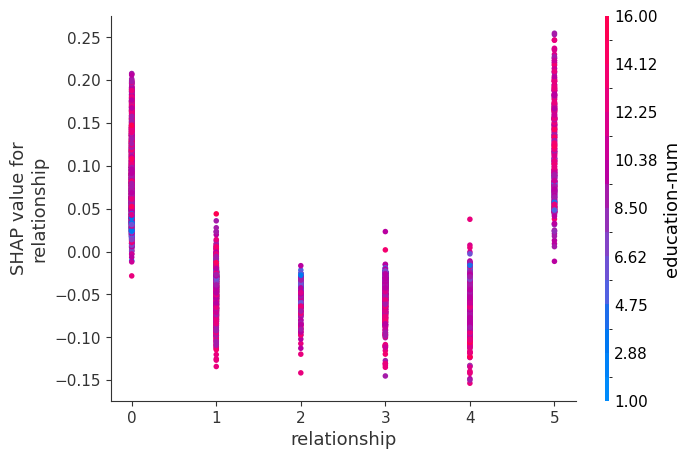

In [39]:
shap_dependence_plot("relationship", class1_shap_values, X_test, encoders['relationship'])

## Intepretation
- The x-axis shows the encoded values for different marital status and relationship. Each number represents a different status as shown in above cells.

- The y-axis shows the SHAP values for each prediction, how much this feature pushes the predictiction toward class 1(>50K)

### Marital Status
- Category 2 (Married-civ-spouse) has the strongest positive impact on high income prediction.
- Married-civ-spouse with higher education-num values have even more positive SHAP values
- Married-civ-spouse with lower education still have positive SHAP values, but not as high
- This shows education amplifies the positive effect of marrying with a civilian spouse
### Relationship
- Category 0 and 5 (husband and wife) has the strongest positive impact on high income prediction.
- Other categories including not-in-family, other-relative, own-child, unmarried have slightly positive and mostly negative impact on high income prediction.
- Same as marital status, education amplifies the positive effect for category 0 and 5.
- Conversely, for other categories, lower educational attainment tends to reduce the predicted value for loan approval.

Base value (probability baseline): 0.1723205627705627
Jane's predicted probability: 0.30333333333333334


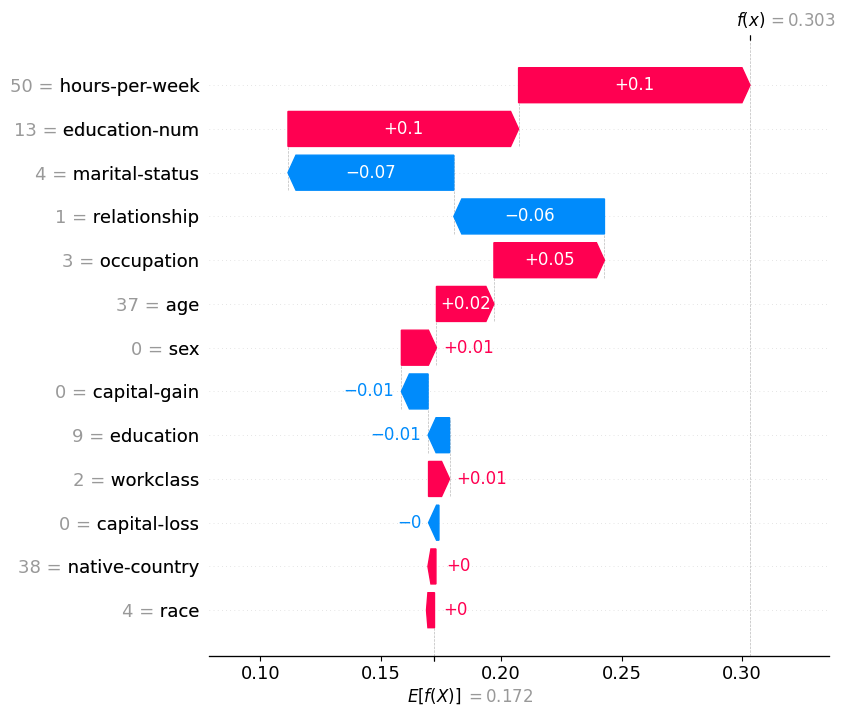

In [40]:
# Return only class-1 probability
f = lambda X: model_adult.predict_proba(X)[:, 1]

explainer = shap.Explainer(f, X_train)
shap_values = explainer(jane_df)

print("Base value (probability baseline):", shap_values.base_values[0])
print("Jane's predicted probability:", f(jane_df)[0])

# Waterfall in probability space
shap.plots.waterfall(shap_values[0], max_display=len(jane_df.columns))

## Intepretation: Waterfall Plot – single prediction explanation

**This plot explains the predicted value for Jane**
- The baseline model output (expected value) is 0.172
- For Jane, the final predicted value is 0.303, which is lower than 0.5, so the result is denied
- The contributions of features are shown as red (push prediction up) or blue (push down)

**Key drivers for Jane:**
- Hours-per-week(+0.1): Working more hours strongly increased the predicted probability.
- Education-num(+0.1): Higher numeric education level also increased the probability.
- Occupation(+0.05) and age(+0.02) slightly increased the predicted probability.
- Marital-status (−0.07) and relationship (−0.06) lowered the prediction. Jane's status for these two features are "never-married", and "not-in-family", interpreted by the model as negative impact for loan approval.

**Critical issue:** Same as global explanation, relying on marital status and relationship as factors that reduce the likelihood of loan approval is unfair. That suggests unfair reasoning, income shouldn’t be predicted based on relationship status.


# LIME

In [41]:
from lime.lime_tabular import LimeTabularExplainer

# Keep only categorical columns that are in X_train
categorical_cols_in_X = [col for col in label_cols if col in X_train.columns]

# Indices of categorical columns
categorical_features = [X_train.columns.get_loc(col) for col in categorical_cols_in_X]

# Mapping: column -> list of original string classes
categorical_names = {
    col: encoders[col].classes_.tolist() for col in categorical_cols_in_X
}

# Initialize LIME explainer
explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['<=50K', '>50K'],
    categorical_features=categorical_features,
    categorical_names=categorical_names,
    mode='classification'
)

predict_fn = lambda x: model_adult.predict_proba(pd.DataFrame(x, columns=X_train.columns))

# Explain Jane’s prediction
exp = explainer.explain_instance(
    data_row=jane_df.values[0],
    predict_fn = predict_fn,
    num_features=13
)

# Notebook view
exp.show_in_notebook(show_table=True)

# Terminal-friendly output
print(exp.as_list())


[('capital-gain <= 0.00', -0.5979129423674785), ('capital-loss <= 0.00', -0.10617311458888919), ('hours-per-week > 45.00', 0.0972610880915458), ('marital-status=4', -0.0697075641570325), ('10.00 < education-num <= 13.00', 0.059921894594637315), ('relationship=1', -0.05510897811711338), ('occupation=3', 0.04489193578806861), ('sex=0', -0.014609876436563472), ('race=4', 0.010470049552515463), ('workclass=2', -0.009251067312433983), ('education=9', -0.0025300528717816994), ('native-country=38', 0.0014347484162455675), ('28.00 < age <= 37.00', 0.0005493201172010958)]


## Intepretation: LIME
### Overall Prediction
- Prediction probabilities: 70% chance of <=50K, 30% chance of >50K
- Model's decision: Predicts Jane earns <=50K(the higher probability)

### Feature Contributions
- The blue bars support the predicticted value to be <=50K. For example having no capital gains strongly leads to low income prediction.
- The orange bars support the predicted value to be >50K. For example, working more than 45 hours per week is the main factor pushing the prediction toward high income.

### Conclusion of LIME
Enen though Jane works long hours, other factors like lack of capital gain/ loss, marital status, and her relationship type outweigh the positive effect of other features, leading to a <=50K prediction.

